In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_score, recall_score

In [3]:
train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

# Ensure that train_images and test_images are prepared from train_data and test_data respectively
train_images = train_data[:, :-1]  # Extract image data
train_labels = train_data[:, -1]    # Extract labels

test_images = test_data[:, :-1]     # Extract test image data
test_labels = test_data[:, -1]       # Extract test labels

# Normalize the pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape images into 28x28 for visualization and further processing
train_images = train_images.reshape(-1, 28, 28)
test_images = test_images.reshape(-1, 28, 28)


# Define class names for Fashion-MNIST
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Shirt',
]

# Flatten the training images (from 28x28) to (784,) for each image
train_images_flat = train_images.reshape(train_images.shape[0], -1)

# Check the new shape
print(f"Flattened train images shape: {train_images_flat.shape}")  # Should be (number_of_train_samples, 784)

# Flatten the test images (from 28x28) to (784,) for each image
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Check the new shape
print(f"Flattened test images shape: {test_images_flat.shape}")  # Should be (number_of_test_samples, 784)

Flattened train images shape: (10000, 784)
Flattened test images shape: (5000, 784)


In [4]:
# Check the shapes to ensure separation worked
print(f"Train Images shape: {train_images.shape}")  # Should be (15000, 28, 28)
print(f"Train Labels shape: {train_labels.shape}")  # Should be (15000,)
print(f"Test Images shape: {test_images.shape}")    # Should be (10000, 28, 28)
print(f"Test Labels shape: {test_labels.shape}")    # Should be (10000,)

Train Images shape: (10000, 28, 28)
Train Labels shape: (10000,)
Test Images shape: (5000, 28, 28)
Test Labels shape: (5000,)


Flattened train images shape: (10000, 784)
Flattened test images shape: (5000, 784)


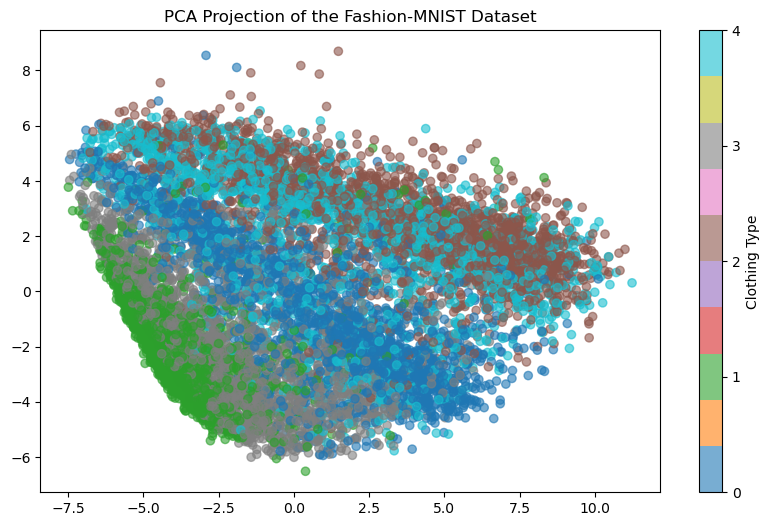

In [5]:
# Flatten images for training and test sets
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Check the new shape
print(f"Flattened train images shape: {train_images_flat.shape}")  # Should be (train_samples, 784)
print(f"Flattened test images shape: {test_images_flat.shape}")    # Should be (test_samples, 784)

# Apply PCA
pca = PCA(n_components=15)
train_pca = pca.fit_transform(train_images_flat)

# Visualize PCA result
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=np.arange(10), label='Clothing Type')
plt.title("PCA Projection of the Fashion-MNIST Dataset")
plt.show()

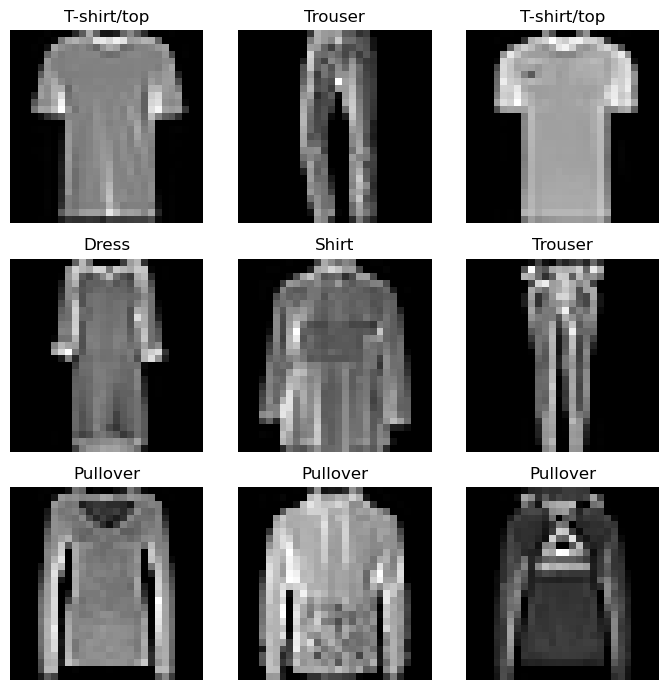

In [6]:
# Plot sample images
def plot_sample_images(images, labels, class_names, samples=9):
    plt.figure(figsize=(7, 7))
    for i in range(samples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 9 images from the training set
plot_sample_images(train_images, train_labels, class_names)

## Cross validation for the decision tree


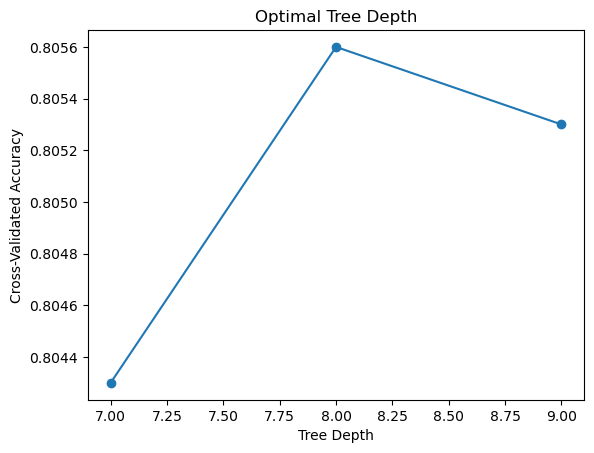

Optimal Tree Depth: 8


In [24]:
depths = range(7, 10)  # Try depths from 1 to 20
avg_scores = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth)
    # 5-fold cross-validation
    scores = cross_val_score(tree, train_images_flat, train_labels, cv=5)
    avg_scores.append(np.mean(scores))

# Plot accuracy vs. tree depth
import matplotlib.pyplot as plt
plt.plot(depths, avg_scores, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal Tree Depth')
plt.show()

# Find the depth with the highest accuracy
optimal_depth = depths[np.argmax(avg_scores)]
print(f"Optimal Tree Depth: {optimal_depth}")


## Cross validation for the decision tree from scratch


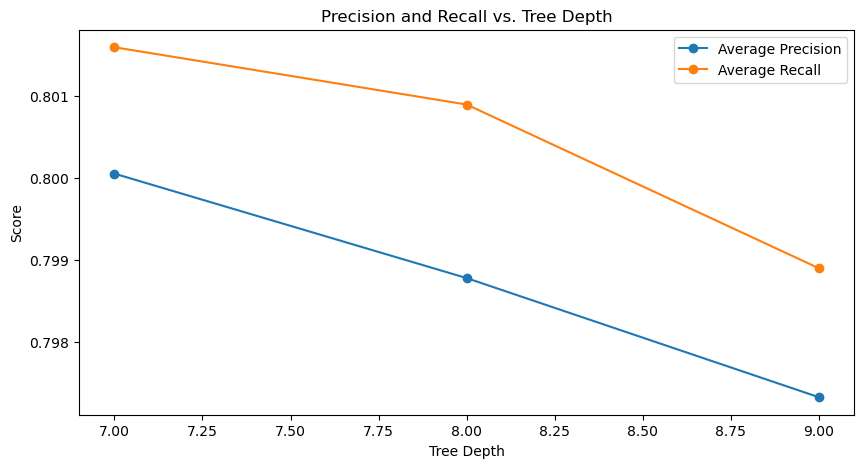

Optimal Depth (based on precision): 7


In [22]:
# Cross-validation function for custom decision tree
def cross_validate_tree_depth(X, y, max_depths, k=3):
    precision_scores = []
    recall_scores = []

    # Iterate over each depth
    for depth in max_depths:
        # Initialize k-fold cross-validation
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        
        precision_fold_scores = []
        recall_fold_scores = []
        
        # Cross-validation for each fold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Train custom decision tree with current depth
            tree = DecisionTree(max_depth=depth)
            tree.fit(X_train, y_train)
            
            # Predict and evaluate
            y_pred = tree.predict(X_test)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            
            precision_fold_scores.append(precision)
            recall_fold_scores.append(recall)
        
        # Record the average precision and recall for this depth
        precision_scores.append(np.mean(precision_fold_scores))
        recall_scores.append(np.mean(recall_fold_scores))
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(max_depths, precision_scores, label='Average Precision', marker='o')
    plt.plot(max_depths, recall_scores, label='Average Recall', marker='o')
    plt.xlabel('Tree Depth')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Tree Depth')
    plt.legend()
    plt.show()

    # Find the optimal depth
    optimal_depth = max_depths[np.argmax(precision_scores)]
    print(f"Optimal Depth (based on precision): {optimal_depth}")
    return optimal_depth

# Usage example: testing depths from 1 to 20
depth_range = list(range(7, 10))
optimal_depth = cross_validate_tree_depth(train_images_flat, train_labels, max_depths=depth_range, k=5)


### Decision tree from scratch

In [25]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    class Node:
        __slots__ = ['feature', 'threshold', 'left', 'right', 'output']
        def __init__(self, feature=None, threshold=None, left=None, right=None, output=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.output = output

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        if (self.max_depth and depth >= self.max_depth) or n_samples < 2:
            return self.Node(output=np.bincount(y).argmax())

        best_feature, best_threshold, best_gain = self._find_best_split(X, y)
        if best_gain <= 0:
            return self.Node(output=np.bincount(y).argmax())

        mask = X[:, best_feature] < best_threshold
        left_node = self._grow_tree(X[mask], y[mask], depth + 1)
        right_node = self._grow_tree(X[~mask], y[~mask], depth + 1)

        return self.Node(feature=best_feature, threshold=best_threshold, 
                         left=left_node, right=right_node)

    def _find_best_split(self, X, y):
        n_features = X.shape[1]
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        current_entropy = self._entropy(y)

        for feature in range(n_features):
            feature_values = X[:, feature]
            thresholds = np.unique(feature_values)[:-1]
            if len(thresholds) == 0:
                continue

            gains = np.array([
                self._fast_information_gain(feature_values, y, threshold, current_entropy)
                for threshold in thresholds
            ])

            max_gain_idx = gains.argmax()
            if gains[max_gain_idx] > best_gain:
                best_gain = gains[max_gain_idx]
                best_feature = feature
                best_threshold = thresholds[max_gain_idx]

        return best_feature, best_threshold, best_gain

    def _fast_information_gain(self, feature_values, y, threshold, parent_entropy):
        mask = feature_values < threshold
        left_counts = np.bincount(y[mask], minlength=self.n_classes)
        right_counts = np.bincount(y[~mask], minlength=self.n_classes)

        n_left = mask.sum()
        n_right = len(y) - n_left
        if n_left == 0 or n_right == 0:
            return 0

        p_left = n_left / len(y)
        p_right = n_right / len(y)

        left_entropy = self._fast_entropy(left_counts)
        right_entropy = self._fast_entropy(right_counts)

        return parent_entropy - (p_left * left_entropy + p_right * right_entropy)

    @staticmethod
    def _fast_entropy(counts):
        probs = counts[counts > 0] / counts.sum()
        return -(probs * np.log2(probs)).sum()

    def _entropy(self, y):
        counts = np.bincount(y)
        probs = counts[counts > 0] / len(y)
        return -(probs * np.log2(probs)).sum()

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, sample):
        node = self.tree
        while node.output is None:
            node = node.left if sample[node.feature] < node.threshold else node.right
        return node.output

#### Evaluation of the model

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1000
           1       0.94      0.92      0.93      1000
           2       0.74      0.86      0.80      1000
           3       0.82      0.85      0.84      1000
           4       0.68      0.49      0.57      1000

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.78      5000
weighted avg       0.79      0.79      0.78      5000



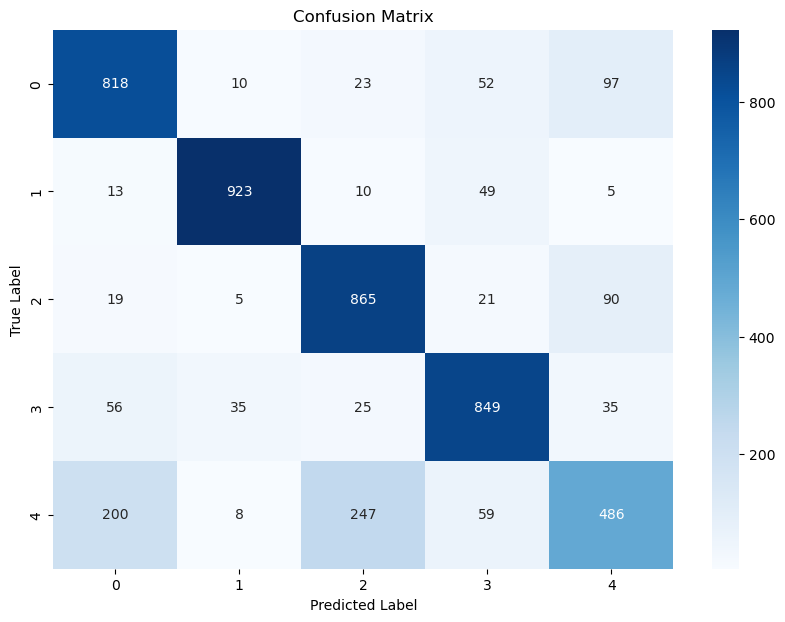

In [26]:
def evaluate_model(model, X_test, y_test):
    # Make predictions using the model
    predictions = model.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, predictions)
    print("Classification Report:")
    print(report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Create and train the decision tree model
tree_model = DecisionTree(max_depth=7)
tree_model.fit(train_images_flat, train_labels)

# Evaluate the model
evaluate_model(tree_model, test_images_flat, test_labels)

### Decision tree with </em>scikit-learn</em>

In [11]:
# Initialize and train the model
dt_model = DecisionTreeClassifier(max_depth=7)
dt_model.fit(train_images_flat, train_labels)

# Predict on the test set
dt_predictions = dt_model.predict(test_images_flat)

# Evaluate the model
print("Decision Tree Classifier Results:")

# Check unique predicted labels
unique_predictions = np.unique(dt_predictions)
print(f"Unique predictions from Decision Tree Classifier: {unique_predictions}")

# Generate classification report with zero_division handling
print(classification_report(test_labels, dt_predictions, zero_division=0))


Decision Tree Classifier Results:
Unique predictions from Decision Tree Classifier: [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.97      0.91      0.94      1000
           2       0.75      0.88      0.81      1000
           3       0.83      0.85      0.84      1000
           4       0.65      0.55      0.60      1000

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



#### Feed-forward neural networks

In [30]:
# One-hot encoding létrehozása a címkékhez
encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_one_hot = encoder.transform(test_labels.reshape(-1, 1))

class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.num_layers = len(layer_sizes)
        self.weights = [np.random.randn(y, x) * np.sqrt(2 / x)
                        for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((y, 1)) for y in layer_sizes[1:]]

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)

    def forward_propagation(self, X):
        activations = [X]
        for l in range(self.num_layers - 1):
            z = self.weights[l] @ activations[-1] + self.biases[l]
            if l == self.num_layers - 2:  # Use softmax in the last layer
                a = self.softmax(z)
            else:
                a = 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Sigmoid for hidden layers
            activations.append(a)
        return activations

    def backward_propagation(self, activations, y):
        m = activations[0].shape[1]
        delta = activations[-1] - y

        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]

        for l in reversed(range(self.num_layers - 1)):
            dW[l] = delta @ activations[l].T / m
            db[l] = np.sum(delta, axis=1, keepdims=True) / m

            if l > 0:
                delta = (self.weights[l].T @ delta) * \
                    (activations[l] * (1 - activations[l]))  # Sigmoid derivative

        return dW, db

    def train(self, X, y, epochs, learning_rate, batch_size=32):
        m = X.shape[1]
        for _ in range(epochs):
            # Shuffle data to ensure randomness in mini-batches
            indices = np.random.permutation(m)
            X_shuffled = X[:, indices]
            y_shuffled = y[:, indices]
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[:, i:i+batch_size]
                y_batch = y_shuffled[:, i:i+batch_size]

                activations = self.forward_propagation(X_batch)
                dW, db = self.backward_propagation(activations, y_batch)

                for l in range(self.num_layers - 1):
                    self.weights[l] -= learning_rate * dW[l]
                    self.biases[l] -= learning_rate * db[l]

    def predict(self, X):
        activations = self.forward_propagation(X)
        return activations[-1]

# Usage:
# Prepare data
X_train = train_images_flat.T  # Transpose for efficiency
y_train = train_labels_one_hot.T

X_test = test_images_flat.T
y_test = test_labels_one_hot.T

# Create and train the model
model = NeuralNetwork([784, 128, 64, 5])
model.train(X_train, y_train, epochs=100, learning_rate=0.01, batch_size=64)

# Evaluate
predictions = model.predict(X_test)
predictions_labels = np.argmax(predictions, axis=0)
test_labels_numeric = np.argmax(y_test, axis=0)

print("Neural Network results:")
print("Accuracy:", accuracy_score(test_labels_numeric, predictions_labels))
print(classification_report(test_labels_numeric, predictions_labels))

c:\Users\l\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Neural Network results:
Accuracy: 0.8174
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1000
           1       0.98      0.95      0.96      1000
           2       0.79      0.85      0.82      1000
           3       0.85      0.88      0.87      1000
           4       0.68      0.59      0.63      1000

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



c:\Users\l\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Results:
Accuracy: 0.8308
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1000
           1       0.95      0.95      0.95      1000
           2       0.83      0.87      0.85      1000
           3       0.88      0.88      0.88      1000
           4       0.73      0.62      0.67      1000

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



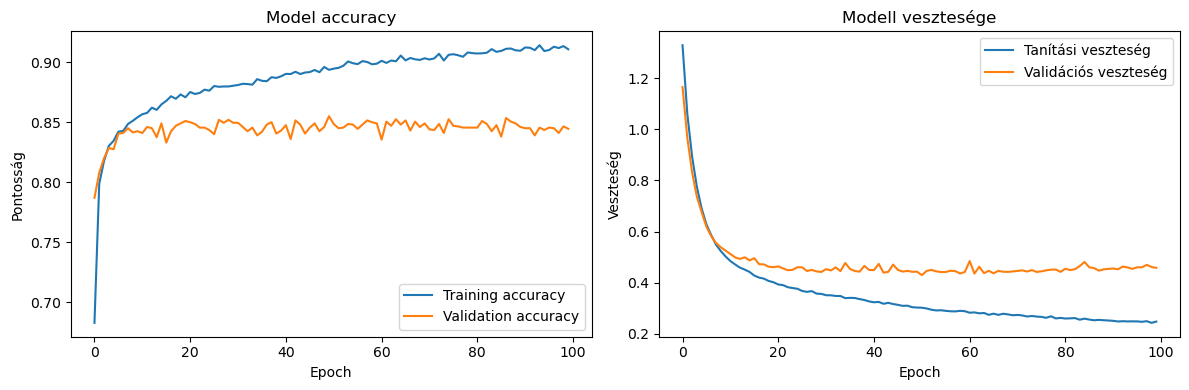

In [31]:
model = Sequential([
    Dense(64, activation='softmax', input_shape=(784,)),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images_flat, train_labels_one_hot,
                    epochs=100, batch_size=32, validation_split=0.2, verbose=0)

predictions_tf = model.predict(test_images_flat)
predictions_tf_labels = np.argmax(predictions_tf, axis=1)

print("\nResults:")
print("Accuracy:", accuracy_score(test_labels, predictions_tf_labels))
print(classification_report(test_labels, predictions_tf_labels))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pontosság')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Tanítási veszteség')
plt.plot(history.history['val_loss'], label='Validációs veszteség')
plt.title('Modell vesztesége')
plt.xlabel('Epoch')
plt.ylabel('Veszteség')
plt.legend()

plt.tight_layout()
plt.show()